In [1]:
import sys 
sys.path.append('../..')
sys.path.append('/opt/anaconda3/lib/python3.7/site-packages')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import numpy as np
import torch as ch
from torch import Tensor
from torch.distributions import Uniform
from torch.distributions.transforms import SigmoidTransform
from torch.distributions.transformed_distribution import TransformedDistribution
from torch.utils.data import DataLoader
from delphi.stats.truncated_logistic_regression import truncated_logistic_regression
from delphi.oracle import Left, Interval
import delphi.utils.constants as consts
import datetime

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True,

# Helpers

In [18]:
STORE_PATH = '/Users/patroklos/LogisticRegression'
STORE_TABLE_NAME = 'log_cos'

store = Store(STORE_PATH)

store.add_table(STORE_TABLE_NAME, { 
    'delphi_cos': float,
    'mle_cos': float,
    'alpha': float, 
    'C': float,
})

Logging in: /Users/patroklos/LogisticRegression/5fe9bac0-6162-45ef-9a7d-12eb023f03ca


## Default Experiment Parameters

In [19]:
# regression parameters
NUM_SAMPLES, DIMS = 10000, 2
LOWER, UPPER = -1, 1

# procedure hyperparameters
args = Parameters({ 
    'epochs': 25,
    'workers': 0, 
    'batch_size': 10,
    'bias': True,
    'num_samples': 100,
    'clamp': True, 
    'radius': 5.0, 
    'var_lr': 1e-2,
    'lr': 1e-1,
    'shuffle': False, 
    'tol': 1e-2,
    'eps': 1e-5,
    'score': True,
    'custom_lr_multiplier': consts.COSINE,
    'var': True,
})

# Logistic Distribution

In [20]:
# define logistic distribution
base_distribution = Uniform(0, 1)
transforms_ = [SigmoidTransform().inv]
logistic = TransformedDistribution(base_distribution, transforms_)

In [21]:
# perform each experiment a total of 10 times
for iter_ in range(10): 
    for C in [-2, -.5, -1, -.5]:
        PREDICATE = Left(Tensor([C]))
        args.__setattr__('phi', PREDICATE)
        # generate random uniform weights
        W = Uniform(LOWER, UPPER).sample(ch.Size([DIMS, 1]))
        W0 = Uniform(LOWER, UPPER).sample(ch.Size([1, 1]))

        # generate data
        X = Uniform(-100, 100).sample(ch.Size([NUM_SAMPLES, DIMS]))
        z = X.mm(W) + W0 + logistic.sample(ch.Size([NUM_SAMPLES, 1]))
        y = ch.where(z > 0, ch.ones(1), ch.zeros(1))
        # truncate
        indices = PREDICATE(z).nonzero(as_tuple=False).flatten()
        z_trunc, y_trunc, x_trunc = z[indices], y[indices], X[indices]

        args.__setattr__('alpha', Tensor([y_trunc.size(0) / NUM_SAMPLES]))

        # truncated logistic regression
        trunc_log_reg = truncated_logistic_regression(args.phi, args.alpha, args)
        results = trunc_log_reg.fit(X, y)
        w, w0 = results.weight.detach().cpu(), results.bias.detach().cpu()
        
        # naive estimates 
        naive_log_reg = LogisticRegression()
        naive_log_reg.fit(X, y.flatten())

        # parameter estimates 
        real_params = ch.cat([W.T, W0], axis=1)
        mle_params = ch.cat([Tensor(naive_log_reg.coef_), Tensor(naive_log_reg.intercept_).unsqueeze(0)], axis=1)
        delphi_params = ch.cat([w, w0.unsqueeze(0)], axis=1)

        # metrics
        mle_cos = cosine_similarity(mle_params, real_params)
        delphi_cos = cosine_similarity(delphi_params, real_params)

        store[STORE_TABLE_NAME].append_row({ 
            'delphi_cos': delphi_cos,
            'mle_cos': mle_cos,
            'alpha': float(args.alpha),
            'C': C,
        })

# close current store
store.close()

==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 2.3342, -0.0411]])
bias grad: tensor([-0.0716])
avg score: 
 [0.0073, 0.0096, 0.0062]
avg loss: 0.38149333146808956
avg top 1: 0.9785000085830688
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 0.0182, -0.0221]])
bias grad: tensor([-0.0144])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 9.3110, -7.6019]])
bias grad: tensor([0.1000])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-1.5358,  1.6458]])
bias grad: tensor([-0.0421])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 0.0322, -0.0264]])
bias grad: tensor([-0.0003])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 4.1982, -3.5678]])
bias grad: tensor([0.1000])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])
avg score: 
 [0.0052, 0.0016, 0.0023]
avg loss: 0.17199107074752296
avg top 1: 0.9861000180244446
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 2.5013, -4.8304]])
bias grad: tensor([0.0542])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-5.6616,  9.3109]])
bias grad: tensor([0.0996])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 1.0036, -1.8414]])
bias grad: tensor([-0.0444])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1554, -0.3359]])
bias grad: tensor([-0.0539])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 0.0813, -0.1627]])
bias grad: tensor([-0.0032])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])
avg score: 
 [-0.0058, -0.0054, 0.0025]
avg loss: 0.20972052767576246
avg top 1: 0.9840999841690063
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-1.8488e-04, -9.5437e-05]])
bias grad: tensor([-2.3842e-06])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])
avg score: 
 [0.0004, 0.0099, 0.0089]
avg loss: 0.21423050417794362
avg top 1: 0.9839000105857849
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 3.0057e-06, -1.3290e-06]])
bias grad: tensor([-4.7684e-08])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 8.2422e-07, -3.8665e-07]])
bias grad: tensor([-2.3842e-08])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 0.0003, -0.0001]])
bias grad: tensor([-1.8877e-05])
avg score: 
 [0.0018, -0.0069, 0.0034]
avg loss: 0.11548078832181342
avg top 1: 0.9890999794006348
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-5.6281e-07,  7.1495e-07]])
bias grad: tensor([-3.5763e-08])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 2.9556, -8.0822]])
bias grad: tensor([0.1000])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-3.9945e-07,  6.9244e-07]])
bias grad: tensor([-3.5763e-08])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 1.0166, -2.6024]])
bias grad: tensor([0.0599])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])
avg score: 
 [-0.0045, -0.0028, 0.0031]
avg loss: 0.11843618586055779
avg top 1: 0.9872000217437744
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[3.2163e-06, 5.4455e-07]])
bias grad: tensor([-3.5763e-08])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0.1574, 0.0341]])
bias grad: tensor([-0.0019])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])
avg score: 
 [0.0067, -0.0096, 0.0064]
avg loss: 0.3411566954413048
avg top 1: 0.9804999828338623
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-0.7851,  0.9550]])
bias grad: tensor([-0.0433])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])
avg score: 
 [0.0087, 0.0038, 0.0065]
avg loss: 0.47936151209796324
avg top 1: 0.9768000245094299
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 0.0002, -0.0001]])
bias grad: tensor([-4.4107e-06])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 5.2216, -3.9925]])
bias grad: tensor([-0.0956])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])
avg score: 
 [0.0067, 0.0056, 0.0088]
avg loss: 0.3256755276807737
avg top 1: 0.9818000197410583
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-5.1217, -9.2767]])
bias grad: tensor([0.1000])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[9.1823e-05, 1.1151e-04]])
bias grad: tensor([-1.5736e-05])
avg score: 
 [0.0094, 0.0019, 0.0062]
avg loss: 0.3423963109817671
avg top 1: 0.9821000099182129
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-2.5837e-04,  4.2081e-05]])
bias grad: tensor([-1.3578e-05])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 0.6150, -0.1804]])
bias grad: tensor([-0.0073])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])
avg score: 
 [-0.0063, -0.0061, 0.005]
avg loss: 0.17439040041283585
avg top 1: 0.9866999983787537
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])
avg score: 
 [-0.0026, -0.0079, 0.0092]
avg loss: 0.32454526916592674
avg top 1: 0.9821000099182129
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-4.0675e-07, -6.2280e-06]])
bias grad: tensor([-2.1458e-07])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 3.8602e-07, -9.0741e-06]])
bias grad: tensor([-3.4571e-07])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])
avg score: 
 [0.0087, 0.0032, 0.0035]
avg loss: 0.14570521705469364
avg top 1: 0.9866999983787537
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 4.9484, -0.5494]])
bias grad: tensor([0.1000])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 2.4708e-05, -4.1041e-06]])
bias grad: tensor([-6.9141e-07])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1366, -0.0286]])
bias grad: tensor([-0.0088])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 6.1854e-06, -1.2406e-06]])
bias grad: tensor([-8.3447e-08])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])
avg score: 
 [0.0059, 0.0008, 0.0093]
avg loss: 0.38421183900493683
avg top 1: 0.9750000238418579
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[8.9579e-06, 2.2255e-05]])
bias grad: tensor([-2.9802e-07])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])
avg score: 
 [-0.0025, 0.0052, 0.0026]
avg loss: 0.10222602920655517
avg top 1: 0.9882000088691711
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-9.6324,  7.5857]])
bias grad: tensor([0.1611])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-9.1447,  5.9636]])
bias grad: tensor([0.1000])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 3.3952, -2.6618]])
bias grad: tensor([-0.0396])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 0.6035, -0.4935]])
bias grad: tensor([-0.0388])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-1.9017e-06,  1.4209e-06]])
bias grad: tensor([-2.3842e-08])
avg score: 
 [-0.0084, -0.0063, 0.005]
avg loss: 0.22756221066348084
avg top 1: 0.9839000105857849
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])
avg score: 
 [-0.0024, -0.0026, 0.0033]
avg loss: 0.29792258868845684
avg top 1: 0.9819999933242798
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 4.8036e-05, -2.1413e-05]])
bias grad: tensor([-2.4438e-06])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 0.3451, -0.2211]])
bias grad: tensor([0.0656])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 0.6860, -0.2852]])
bias grad: tensor([-0.0363])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 0.0003, -0.0002]])
bias grad: tensor([-6.1750e-06])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-5.3334e-07,  4.3946e-07]])
bias grad: tensor([-2.3842e-08])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])
avg score: 
 [0.0051, 0.002, 0.007]
avg loss: 0.15005732243528253
avg top 1: 0.9858999848365784
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-2.5973, -9.6267]])
bias grad: tensor([0.1000])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-9.1291e-05, -2.8883e-04]])
bias grad: tensor([-3.2425e-06])
avg score: 
 [-0.0088, -0.001, 0.0049]
avg loss: 0.17923044376712233
avg top 1: 0.9868999719619751
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 1.3072, -2.2493]])
bias grad: tensor([-0.0335])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-6.6660,  9.1653]])
bias grad: tensor([0.1000])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 3.3632e-06, -3.2789e-06]])
bias grad: tensor([-2.0266e-07])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 0.9236, -1.2198]])
bias grad: tensor([-0.0139])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])
avg score: 
 [-0.0027, 0.0069, 0.0096]
avg loss: 0.5549963569318618
avg top 1: 0.9718999862670898
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-4.7545,  1.6552]])
bias grad: tensor([0.1000])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 2.2270, -1.7059]])
bias grad: tensor([0.0999])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-4.3160,  1.5881]])
bias grad: tensor([0.1125])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-0.0025,  0.0018]])
bias grad: tensor([-4.9937e-05])
avg score: 
 [-0.0063, 0.0034, 0.0092]
avg loss: 0.6578764345358131
avg top 1: 0.9538999795913696
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 3.0341e-06, -1.4067e-04]])
bias grad: tensor([-1.3030e-05])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0.0476, 1.5892]])
bias grad: tensor([0.1000])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 1.5304, -3.6088]])
bias grad: tensor([0.0993])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-2.8621,  8.3473]])
bias grad: tensor([0.0603])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-2.4378e-07,  5.0253e-07]])
bias grad: tensor([-1.1921e-08])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-1.9359,  6.7786]])
bias grad: tensor([0.0995])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])
avg score: 
 [0.0061, -0.0034, 0.0098]
avg loss: 0.1334501760590736
avg top 1: 0.9829000234603882
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 4.7288, -9.7847]])
bias grad: tensor([0.1000])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-1.9929e-06,  2.7964e-06]])
bias grad: tensor([-1.4305e-07])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])
avg score: 
 [-0.0097, -0.005, 0.0091]
avg loss: 0.4042724281356351
avg top 1: 0.9800999760627747
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 5.2068, -0.5137]])
bias grad: tensor([0.1000])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0.0810, 0.0084]])
bias grad: tensor([-0.0141])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])
avg score: 
 [0.0011, 0.0054, 0.0037]
avg loss: 0.23692161500369716
avg top 1: 0.982200026512146
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-6.6517,  1.0494]])
bias grad: tensor([0.1000])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-0.8091,  0.2655]])
bias grad: tensor([-0.0711])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])
avg score: 
 [-0.0065, -0.0087, 0.0031]
avg loss: 0.35238567023564527
avg top 1: 0.9781000018119812
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-2.0214, 12.9611]])
bias grad: tensor([0.2000])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 1.3241, -7.5212]])
bias grad: tensor([0.1000])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-0.5227,  3.7322]])
bias grad: tensor([0.0741])
avg score: 
 [0.0069, 0.0017, 0.0055]
avg loss: 0.17327983593807114
avg top 1: 0.9865000247955322
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-0.0003, -0.0006]])
bias grad: tensor([-1.7673e-05])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-0.7830, -1.6884]])
bias grad: tensor([0.0657])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[1.2137e-06, 2.3438e-06]])
bias grad: tensor([-3.5763e-08])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[3.5625, 7.0022]])
bias grad: tensor([0.0998])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])
avg score: 
 [0.0064, -0.0028, 0.002]
avg loss: 0.2446978142911458
avg top 1: 0.9847999811172485
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[9.9664, 6.1349]])
bias grad: tensor([0.1000])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-4.0740, -2.3812]])
bias grad: tensor([0.0997])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0.0991, 0.0527]])
bias grad: tensor([-0.0060])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[8.2941, 4.1401]])
bias grad: tensor([0.1000])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[9.9321, 6.1669]])
bias grad: tensor([0.1000])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-1.0923, -0.7177]])
bias grad: tensor([-0.0325])
avg score: 
 [0.0033, -0.0037, 0.0032]
avg loss: 0.18857947901965802
avg top 1: 0.9843999743461609
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 0.2633, -0.0115]])
bias grad: tensor([-0.0325])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])
avg score: 
 [0.0014, -0.0081, 0.0028]
avg loss: 0.36811003597040387
avg top 1: 0.9807999730110168
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-8.4028,  3.0550]])
bias grad: tensor([0.1000])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-8.1368e-05,  9.4671e-05]])
bias grad: tensor([-1.9908e-06])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 4.3277, -3.1501]])
bias grad: tensor([0.1000])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 3.2501, -1.9500]])
bias grad: tensor([0.0941])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-0.0128,  0.0100]])
bias grad: tensor([-0.0002])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-7.0056,  5.9524]])
bias grad: tensor([0.1504])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 0.1491, -0.2210]])
bias grad: tensor([0.0589])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 0.0348, -0.0241]])
bias grad: tensor([-0.0004])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 0.3535, -0.2013]])
bias grad: tensor([-0.0523])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 6.9162e-06, -3.7080e-06]])
bias grad: tensor([-1.0729e-07])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-0.0018,  0.0023]])
bias grad: tensor([-3.5346e-05])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 3.5636, -2.5099]])
bias grad: tensor([-0.0449])
avg score: 
 [-0.0028, -0.0019, 0.0057]
avg loss: 0.4763739928140266
avg top 1: 0.9291999936103821
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 5.2397e-06, -2.6328e-06]])
bias grad: tensor([-8.3447e-08])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-0.0681,  0.0409]])
bias grad: tensor([-0.0021])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])
avg score: 
 [0.0087, 0.0064, 0.0058]
avg loss: 0.22378622258180125
avg top 1: 0.9850000143051147
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[1.2746, 2.8319]])
bias grad: tensor([0.0935])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[1.7391, 3.1338]])
bias grad: tensor([0.0587])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-5.7503, -8.6801]])
bias grad: tensor([0.1000])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-1.8573e-05, -1.4014e-05]])
bias grad: tensor([-2.3842e-06])
avg score: 
 [0.002, 0.0019, 0.0094]
avg loss: 0.16021211811093275
avg top 1: 0.982699990272522
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 2.1599e-07, -8.3312e-07]])
bias grad: tensor([-1.1921e-08])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])
avg score: 
 [-0.0064, -0.0083, 0.0064]
avg loss: 0.18622368071080364
avg top 1: 0.9871000051498413
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-9.6758e-06,  6.9689e-06]])
bias grad: tensor([-3.0994e-07])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 4.3971, -4.8859]])
bias grad: tensor([0.0970])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 2.3764, -1.7260]])
bias grad: tensor([0.1772])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-1.9054,  2.1178]])
bias grad: tensor([0.1000])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-4.0684,  3.4257]])
bias grad: tensor([-0.0418])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])
avg score: 
 [-0.0061, -0.0079, 0.0048]
avg loss: 0.23068218998683973
avg top 1: 0.9822999835014343
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-0.3998, -1.1704]])
bias grad: tensor([-0.0217])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])
avg score: 
 [-0.0084, 0.0074, 0.0032]
avg loss: 0.2585821096624822
avg top 1: 0.9825000166893005
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-0.0004, -0.0005]])
bias grad: tensor([-2.7066e-05])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])
avg score: 
 [-0.0085, 0.0043, 0.0052]
avg loss: 0.33328592567186377
avg top 1: 0.9786999821662903
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-9.1474, -2.1156]])
bias grad: tensor([0.0986])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-2.3023, -0.0657]])
bias grad: tensor([-0.0376])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 8.8742, -3.1419]])
bias grad: tensor([0.0313])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0.2350, 0.7575]])
bias grad: tensor([0.1000])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-0.4756, -0.2795]])
bias grad: tensor([0.0517])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 0.0014, -0.0008]])
bias grad: tensor([-1.5128e-05])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-0.0010, -0.0003]])
bias grad: tensor([-1.8948e-05])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-1.0482e-07, -2.7878e-07]])
bias grad: tensor([-2.3842e-08])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 2.0803, -0.6953]])
bias grad: tensor([-0.0529])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 4.5154e-05, -6.2638e-06]])
bias grad: tensor([-4.8876e-07])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-12.9564,   0.8224]])
bias grad: tensor([0.1226])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-3.9166,  2.5318]])
bias grad: tensor([0.1368])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 0.5160, -0.4119]])
bias grad: tensor([0.0009])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-0.0455, -0.0246]])
bias grad: tensor([-0.0017])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-0.6490, -0.0586]])
bias grad: tensor([-0.0223])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-1.5841,  0.6916]])
bias grad: tensor([0.0794])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 1.3796, -0.6748]])
bias grad: tensor([-0.0678])
avg score: 
 [0.0045, 0.0042, 0.0013]
avg loss: 0.4372274090783685
avg top 1: 0.9189000129699707
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-1.2694,  0.7312]])
bias grad: tensor([0.0510])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 1.9850, -0.8103]])
bias grad: tensor([0.0975])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])
avg score: 
 [0.0017, 0.0089, 0.0098]
avg loss: 0.2892191370803832
avg top 1: 0.9832000136375427
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[2.4234, 1.6505]])
bias grad: tensor([0.1000])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-8.0586, -8.0558]])
bias grad: tensor([0.2000])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-2.1202, -1.8289]])
bias grad: tensor([-0.0464])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[2.4230, 2.5663]])
bias grad: tensor([0.0772])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[5.0558e-05, 6.8847e-05]])
bias grad: tensor([-1.2517e-06])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[8.4719, 8.1901]])
bias grad: tensor([0.0996])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0.0609, 0.0684]])
bias grad: tensor([-0.0011])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[-2.0544, -1.9097]])
bias grad: tensor([-0.0438])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[4.1704, 3.9706]])
bias grad: tensor([0.0618])
avg score: 
 [0.0826, 0.0438, 0.0091]
avg loss: 0.0929462117326857
avg top 1: 0.9801999926567078
==> Preparing dataset truncated_logistic_regression..
log reg shape: torch.Size([1, 2])


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[8.0556, 3.7523]])
bias grad: tensor([0.2000])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0.7977, 0.3307]])
bias grad: tensor([0.0604])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[ 5.1601e-04, -8.6321e-05]])
bias grad: tensor([-8.8483e-05])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])


  0%|          | 0/1000 [00:00<?, ?it/s]

weight grad: tensor([[0., 0.]])
bias grad: tensor([0.])
avg score: 
 [-0.0043, 0.0067, 0.0097]
avg loss: 0.15612289686774067
avg top 1: 0.9793000221252441


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# Results

In [22]:
reader = CollectionReader(STORE_PATH)
results = reader.df(STORE_TABLE_NAME)
reader.close() # close reader
results.head()

100%|██████████| 1/1 [00:00<00:00, 79.23it/s]


,delphi_cos,mle_cos,alpha,C,exp_id
0,0.768640,0.999995,0.5287,-2.0,5fe9bac0-6162-45ef-9a7d-12eb023f03ca
1,0.619638,0.957193,0.5016,-0.5,5fe9bac0-6162-45ef-9a7d-12eb023f03ca
2,0.220320,0.999964,0.5079,-1.0,5fe9bac0-6162-45ef-9a7d-12eb023f03ca
3,0.994286,0.992911,0.4957,-0.5,5fe9bac0-6162-45ef-9a7d-12eb023f03ca
4,0.983631,0.999912,0.5020,-2.0,5fe9bac0-6162-45ef-9a7d-12eb023f03ca


# All Trials

all trials:


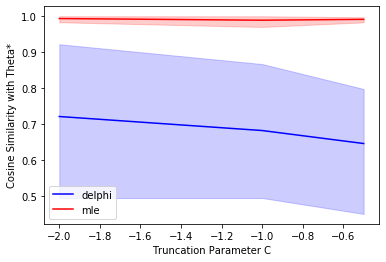

In [23]:
print("all trials:")

# variance vs param mse
sns.lineplot(data=results, x='C', y='delphi_cos', label='delphi', color='blue')
ax = sns.lineplot(data=results, x='C', y='mle_cos', label='mle', color='red')
ax.set(xlabel='Truncation Parameter C', ylabel='Cosine Similarity with Theta*')
plt.show()

# Remove Best and Worst Trial from Results

In [24]:
print("remove best and worst trials:")

# plot results for regression parameter MSE
sns.lineplot(data=results.drop(noise_lambda('unknown_param_mse')), x='var', y='unknown_param_mse', label='unknown', color='blue')
sns.lineplot(data=results.drop(noise_lambda('known_param_mse')), x='var', y='known_param_mse', label='known', color='purple')
ax = sns.lineplot(data=results.drop(noise_lambda('ols_param_mse')), x='var', y='ols_param_mse', label='ols', color='red')
ax.set(xlabel='Noise Variance', ylabel='Squared Error Theta*')
plt.show()

# plot results for regression parameter MSE
sns.lineplot(data=results.drop(noise_lambda('unknown_var_mse')), x='var', y='unknown_var_mse', label='unknown', color='blue')
ax = sns.lineplot(data=results.drop(noise_lambda('ols_var_mse')), x='var', y='ols_var_mse', label='ols', color='red')
ax.set(xlabel='Noise Variance', ylabel='Squared Error Sigma^2*')
plt.show()

remove best and worst trials:


NameError: name 'noise_lambda' is not defined

In [95]:
s = Store('/home/pstefanou/LogisticRegression/', 'ae6627d0-9b20-49ca-9aca-73d0a07637c0')

In [97]:
s.close()